# Analyze HACC IO

In [1]:
notebook_name = "hacc"

## System Imports

In [2]:
import socket
import os
import time
from time import sleep

## Create Dask Cluster for analysis

### Dask Job Queue Imports

In [3]:
import dask_jobqueue
from dask_jobqueue import LSFCluster

/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


### Dask Worker configuration
When we use dask for analysis, we need to consider the type of analysis. In this case we plan to utilize dask dataframes for analysis that is typically memory intensive. Therefore, we allocate the whole memory per node and use only 4 worker processes per node. More worker processes reduce memory available per worker resulting in frequent memory swap from filesystem.

In [4]:
node_memory = 1600 # node memory in GB
n_workers_per_node = 16 # number of worker processes per node
n_threads_per_worker = 1
worker_time = 120 # job time per node for worker
worker_queue = "pdebug" # queue to be used per worker

Other configurations we can compute

In [5]:
import socket
host = socket.gethostname()
dashboard_address = '{}:8788'.format(socket.gethostname())
memory = '{}GB'.format(node_memory/n_workers_per_node)
job_extra = ['-nnodes 1', 
             '-G asccasc', 
             '-q {}'.format(worker_queue), 
             '-W {}'.format(worker_time), 
             '-o {}.log'.format(notebook_name), 
             '-e {}.log'.format(notebook_name)]
local_directory="/p/gpfs1/iopp/temp/"

### Create Dask Cluster 

In [6]:
import dask.dataframe as dd
from dask.distributed import wait, progress
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

In [7]:
filter_groups_indices = ['tmid', 'proc_id', 'file_id']

In [8]:
clusters = {}
for i, index in enumerate(filter_groups_indices):
    clusters[index] = LSFCluster(cores = n_workers_per_node*n_threads_per_worker,processes=n_workers_per_node, memory='{}GB'.format(node_memory), 
                     header_skip=['-n ','-R','-M', '-P', '-W 00:30'], 
                     job_extra = job_extra, 
                     death_timeout=worker_time*60,
                     local_directory =f"{local_directory}/{index}",
                     use_stdin=True, host = host,dashboard_address = f'{socket.gethostname()}:{8788+i}')
local_cluster = LocalCluster(n_workers=8,local_directory =f"{local_directory}/local", dashboard_address= f':8797', memory_limit=0)

{'cls': <class 'distributed.scheduler.Scheduler'>, 'options': {'protocol': 'tcp://', 'interface': None, 'host': 'lassen708', 'dashboard_address': 'lassen708:8788', 'security': None}}
{'cls': <class 'distributed.scheduler.Scheduler'>, 'options': {'protocol': 'tcp://', 'interface': None, 'host': 'lassen708', 'dashboard_address': 'lassen708:8789', 'security': None}}
{'cls': <class 'distributed.scheduler.Scheduler'>, 'options': {'protocol': 'tcp://', 'interface': None, 'host': 'lassen708', 'dashboard_address': 'lassen708:8790', 'security': None}}


### Dask Analysis Imports

In [9]:
# workers = n_workers_per_node
# timeline_cluster = LocalCluster(n_workers=workers,local_directory=f"{local_directory}/timeline")
# file_cluster = LocalCluster(n_workers=workers,local_directory =f"{local_directory}/file")
# local_cluster = LocalCluster(n_workers=workers,local_directory =f"{local_directory}/local")

In [10]:
#import os
#hosts_env= os.environ.get("LLNL_COMPUTE_NODES", "localhost[]")
#print(hosts_env)
#import re
#hosts = re.split('\[|\]|,', hosts_env)[1:-1]
#hosts = ["lassen" +s for s in hosts]
#print(hosts)

In [11]:
##hostname = hosts[0]
#print(hostname)
#!ssh ${hostname} "pid=\$(ps aux | grep 'dask' | awk '{print \$2}' | head -1); echo \$pid |xargs kill"

In [12]:
# from dask.distributed import Client, SSHCluster
# timeline_cluster = SSHCluster(
#     [hosts[0]],
#     connect_options={"known_hosts": None},
#     worker_options={"nthreads": n_threads_per_worker, "n_workers": n_workers_per_node,  "local_directory" :f"{local_directory}/timeline"},
#     scheduler_options={"port": 0, "dashboard_address": ':8799'}
# )
# file_cluster = SSHCluster(
#     [hosts[1]],
#     connect_options={"known_hosts": None},
#     worker_options={"nthreads": n_threads_per_worker, "n_workers": n_workers_per_node,  "local_directory" :f"{local_directory}/file"},
#     scheduler_options={"port": 0, "dashboard_address": ':8798'}
   
# )


In [13]:
# cluster = SSHCluster([hosts[0]],
#     connect_options={"known_hosts": None})
# client = Client(cluster)

In [14]:
#cluster.scale(n_workers_per_node)

### Create Dask Client

In [15]:
clients = {}
for index in filter_groups_indices:
    clients[index] = Client(clusters[index], set_as_default=False)
local_client = Client(local_cluster)
#timeline_client = 
#file_client = Client(file_cluster, set_as_default=True)


In [16]:
#timeline_cluster.scale(n_workers)

for index in filter_groups_indices:
    clusters[index].scale(n_workers_per_node * 2)

In [17]:
for index in filter_groups_indices:
    print(clients[index])

<Client: 'tcp://192.168.66.200:41961' processes=0 threads=0, memory=0 B>
<Client: 'tcp://192.168.66.200:39031' processes=0 threads=0, memory=0 B>
<Client: 'tcp://192.168.66.200:38741' processes=0 threads=0, memory=0 B>


In [18]:
local_client

<Client: 'tcp://127.0.0.1:37235' processes=8 threads=128>

In [19]:
#file_client

In [20]:
def wait_until_workers_alive(index, client, cluster, n_workers):
        # Get current number of workers
        current_n_workers = len(client.scheduler_info()['workers'])
        # Wait until enough number of workers alive
        while (client.status == 'running' and current_n_workers < n_workers):
            # Print current status
            print(f"{current_n_workers}/{n_workers} workers running for client {index}", end="\r")
            # Try correcting state
            cluster._correct_state()
            # Sleep a little
            sleep(5)
            # Get current number of workers
            current_n_workers = len(client.scheduler_info()['workers'])
        #print(f"All {n_workers} workers alive for client {index}\r\n", end="")
async def keep_workers_alive(index, client, cluster, n_workers):
        # While the job is still executing
        while True:
            # Wait a second
            await asyncio.sleep(5)
            # Check workers
            wait_until_workers_alive(index, client, cluster, n_workers)

In [21]:
import asyncio

In [22]:
for i, index in enumerate(filter_groups_indices):
    wait_until_workers_alive(i, clients[index], clusters[index], n_workers_per_node/2)
    keep_alive_task_2 = asyncio.create_task(keep_workers_alive(i, clients[index], clusters[index], n_workers_per_node/2))
#wait_until_workers_alive(1, file_client, file_cluster, 4)
#keep_alive_task_1 = asyncio.create_task(keep_workers_alive(1, file_client, file_cluster, n_workers))

### Spawn cluster nodes

In [23]:
#keep_alive_task_1.cancel()
#keep_alive_task_2.cancel()

## Analysis Utility Functions

### Progress Bars

In [24]:
pbar = ProgressBar()
pbar.register()

### Timer functions

In [25]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

### Threading process 

In [26]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

### Application Logs in Parquet format

In [27]:
parquet_folder="/p/gpfs1/iopp/recorder_app_logs/genome_pegasus/nodes-32/_parquet"
#parquet_folder="/p/gpfs1/iopp/recorder_app_logs/hacc/nodes-32/_parquet"

In [28]:
is_partitioned = os.path.exists(f"{parquet_folder}/partitioned/_common_metadata")
print(is_partitioned)

True


In [29]:
#!rm -rf $parquet_folder/partitioned/*

In [30]:
#!du -sh $parquet_folder/*
#
import glob
import math

In [31]:
%%time
if  not is_partitioned:
    files = glob.glob(f"{parquet_folder}/partitioned/*.parquet", recursive=True)
    
    for f in files:
        os.remove(f)
    files = glob.glob(f"{parquet_folder}/*.parquet", recursive=True)
    file_size = 0
    for f in files:
        file_size = file_size + os.path.getsize(f)
    ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")
    ddf = ddf.repartition(partition_size='4GB')
    dd.to_parquet(ddf, f"{parquet_folder}/partitioned/")
    #client.cancel(ddf)
    files = glob.glob(f"{parquet_folder}/partitioned/*.parquet", recursive=True)
    fs = 0
    min_fs = -1
    max_fs = 0
    for f in files:
        file_size = os.path.getsize(f)
        if min_fs == -1 or min_fs > file_size:
            min_fs = file_size
        if max_fs < file_size:
            max_fs = file_size
        fs = fs + file_size

    print(f"{len(files)} files size: average :{fs/len(files)/1024.0/1024.0} min: {min_fs/1024.0/1024.0} max: {max_fs/1024.0/1024.0}")
    is_partitioned = True

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs


In [32]:
!ls -l $parquet_folder/partitioned/* | wc -l

103


In [33]:
files = glob.glob(f"{parquet_folder}/partitioned/*.parquet", recursive=True)
fs = 0
min_fs = -1
max_fs = 0
for f in files:
    file_size = os.path.getsize(f)
    if min_fs == -1 or min_fs > file_size:
        min_fs = file_size
    if max_fs < file_size:
        max_fs = file_size
    fs = fs + file_size

print(f"{len(files)} file size: average :{fs/len(files)/1024.0/1024.0} min: {min_fs/1024.0/1024.0} max: {max_fs/1024.0/1024.0}")

101 file size: average :557.1953690500543 min: 66.02931213378906 max: 813.728705406189


In [34]:
import functools

def minmax(aa):
    return functools.reduce(lambda mm,xx : ( min(mm[0],xx),max(mm[1],xx)) , aa, ( aa[0],aa[0],))
def load_json_interval(filename, JSON_INDEX):
    if filename:
        f = open(filename)
        data = json.load(f)
        min_val, max_val = minmax(data[JSON_INDEX])
        return [min_val, max_val]
    else:
        return [];
def load_json_array(filename, JSON_INDEX):
    if filename:
        f = open(filename)
        data = json.load(f)
        
        return np.array(data[JSON_INDEX]).astype(np.int64)
    else:
        return [];

def merge_array(x, y):
    z = np.union1d(x, y)
    del x
    del y
    return z

def cal_len(x):
    return len(x)

def calculate_array(INDEX, JSON_INDEX):
    with clients[INDEX].as_current():
        files = glob.glob(f"{parquet_folder}/rank_*.json", recursive=True)
        TOTAL_JSON_FILES = len(files)
        JSON_MAX_DEPTH = math.ceil(math.sqrt(TOTAL_JSON_FILES))
        depth = list(range(0, JSON_MAX_DEPTH+1))
        depth.reverse()
        output = [0]*(JSON_MAX_DEPTH+1)
        pieces = 2**JSON_MAX_DEPTH
        non_delayed = []
        for x in depth:
            depth_ret = []
            if (x == JSON_MAX_DEPTH):
                for file in files:
                    depth_ret.append(dask.delayed(load_json_array)(file, JSON_INDEX))
            else:
                elements_next_level = len(output[x+1])
                num_elements = elements_next_level
                if elements_next_level % 2 == 1:
                    num_elements = num_elements - 1
                for i in range(0, num_elements , 2):
                    depth_ret.append(dask.delayed(merge_array)(output[x+1][i], output[x+1][i+1]))
                if elements_next_level % 2 == 1:
                    depth_ret.append(output[x+1][elements_next_level - 1])
                output[x+1] = 0
            output[x] = depth_ret
        string_list = dask.compute(output)
    return string_list[0][0][0]

def calculate_interval(INDEX, JSON_INDEX):
    with clients[INDEX].as_current():
        files = glob.glob(f"{parquet_folder}/rank_*.json", recursive=True)
        TOTAL_JSON_FILES = len(files)
        JSON_MAX_DEPTH = math.ceil(math.sqrt(TOTAL_JSON_FILES))
        depth = list(range(0, JSON_MAX_DEPTH+1))
        depth.reverse()
        output = [0]*(JSON_MAX_DEPTH+1)
        pieces = 2**JSON_MAX_DEPTH
        non_delayed = []
        for x in depth:
            depth_ret = []
            if (x == JSON_MAX_DEPTH):
                for file in files:
                    depth_ret.append(dask.delayed(load_json_interval)(file, JSON_INDEX))
            else:
                elements_next_level = len(output[x+1])
                num_elements = elements_next_level
                if elements_next_level % 2 == 1:
                    num_elements = num_elements - 1
                for i in range(0, num_elements , 2):
                    depth_ret.append([dask.delayed(min)(output[x+1][i][0], output[x+1][i+1][0]), dask.delayed(max)(output[x+1][i][1], output[x+1][i+1][1])])
                if elements_next_level % 2 == 1:
                    depth_ret.append(output[x+1][elements_next_level - 1])
                output[x+1] = 0
            output[x] = depth_ret
        string_list = dask.compute(output)
    min_val, max_val = string_list[0][0][0][0], string_list[0][0][0][1]
    return min_val, max_val

In [35]:
import pandas as pd
def filter_array(INDEX, processlist, column):
    if len(processlist) == 0:
        return []
    ddf = filter_groups_ddf[INDEX]
    #ddf_index = 
    list_i = pd.Index(processlist).astype(np.int64)
    good_keys = list_i.intersection(ddf.index)
    print("processlist ", good_keys)
    if len(good_keys) == 0:
        return []
    file_ddf = ddf.loc[good_keys,:]
    read_df, write_df, metadata_df = dask.compute(file_ddf[(file_ddf['io_cat'] == 1)][column].unique(),
                                                  file_ddf[(file_ddf['io_cat'] == 2)][column].unique(),
                                                  file_ddf[(file_ddf['io_cat'] == 3)][column].unique())
    del file_ddf 
    return read_df
def filter_interval(INDEX, start, end, column):
    #order is important we want to first select correct time range then do filters.
    ddf = filter_groups_ddf[INDEX]
    time_df = ddf.loc[start:end]
    read_df, write_df, metadata_df = dask.compute(time_df[(time_df['io_cat'] == 1)][column].unique(),
                                                  time_df[(time_df['io_cat'] == 2)][column].unique(),
                                                  time_df[(time_df['io_cat'] == 3)][column].unique())
    del time_df 
    return read_df

def calculate_metrics_interval(INDEX, MAX_DEPTH, COLUMN, MIN, MAX):
    with clients[INDEX].as_current():
        pieces = 2**MAX_DEPTH
        interval = math.floor(MAX*1.0/pieces)
        depth = list(range(0, MAX_DEPTH+1))
        depth.reverse()
        output = [0]*(MAX_DEPTH+1)
        time_range = np.arange(MIN, MAX, interval)
        for x in depth:
            depth_ret = []
            if (x == MAX_DEPTH):
                for i in time_range:
                    #print(i)
                    depth_ret.append(dask.delayed(filter_interval)(INDEX, i, i + interval, COLUMN))
            else:
                pieces = len(output[x+1])
                if pieces % 2 == 1:
                    pieces = pieces - 1
                for i in range(0, pieces , 2):
                    depth_ret.append(dask.delayed(merge_array)(output[x+1][i], output[x+1][i+1]))
                pieces = len(output[x+1])
                if pieces % 2 == 1:
                    depth_ret.append(output[x+1][pieces - 1])
                for index, val in enumerate(output[x+1]):
                    output[x+1][index] = dask.delayed(cal_len)(val)
            output[x] = depth_ret
        metrics = dask.compute(output)
    return metrics
def calculate_metrics_array(INDEX, MAX_DEPTH, JSON_INDEX, column):
    
    with clients[INDEX].as_current():
        str_list = calculate_array(INDEX, JSON_INDEX)
        pieces = 2**MAX_DEPTH
        interval = math.floor(len(str_list)*1.0/pieces)
        if interval == 0:
            pieces = len(str_list)
            interval = 1
            MAX_DEPTH = math.ceil(math.sqrt(pieces))
        depth = list(range(0, MAX_DEPTH+1))
        depth.reverse()
        output = [0]*(MAX_DEPTH+1)
        non_delayed = []
        for x in depth:
            depth_ret = []
            if (x == MAX_DEPTH):
                for i in range(0, len(str_list), interval):
                    #print(i,  i + interval)
                    depth_ret.append(dask.delayed(filter_array)(INDEX, str_list[i: i + interval], column))
            else:
                elements_next_level = len(output[x+1])
                elements = elements_next_level
                if elements_next_level % 2 == 1:
                    elements = elements - 1
                for i in range(0, elements , 2):
                    depth_ret.append(dask.delayed(merge_array)(output[x+1][i], output[x+1][i+1]))
                if elements_next_level % 2 == 1:
                    depth_ret.append(output[x+1][elements_next_level - 1])
                for index, val in enumerate(output[x+1]):
                    output[x+1][index] = dask.delayed(cal_len)(val)
            output[x] = depth_ret
        metrics = dask.compute(output)
    return metrics

In [36]:
import math
import dask
import math
import dask.array as da
import json

In [37]:
def compute_process_metrics(MAX_DEPTH):
    INDEX = 'proc_id'
    JSON_INDEX = 'processes'
    COLUMN = 'file_id'
    MIN, MAX = calculate_interval(INDEX, JSON_INDEX)
    process_metrics = calculate_metrics_interval(INDEX, MAX_DEPTH, COLUMN, MIN, MAX)
    return process_metrics

In [38]:
def compute_file_metrics(MAX_DEPTH):
    INDEX = 'file_id'
    JSON_INDEX = 'filenames'
    COLUMN = 'proc_id'
    MIN, MAX = calculate_interval(INDEX, JSON_INDEX)
    file_metrics = calculate_metrics_interval(INDEX, MAX_DEPTH, COLUMN, MIN, MAX)
    return file_metrics

In [39]:
def compute_process_metrics_2(MAX_DEPTH):
    INDEX = 'proc_id'
    JSON_INDEX = 'processes'
    COLUMN = 'file_id'
    file_metrics = calculate_metrics_array(INDEX, MAX_DEPTH,JSON_INDEX, COLUMN)
    return file_metrics

In [40]:
def compute_timeline_metrics(MAX_DEPTH):
    INDEX = 'tmid'
    COLUMN = 'proc_id'
    f = open(f'{parquet_folder}/global.json')
    data = json.load(f)
    MIN, MAX = 0, math.ceil(data['max_tend'])
    print(MIN, MAX)
    timeline_metrics = calculate_metrics_interval(INDEX, MAX_DEPTH, COLUMN, MIN, MAX)
    return timeline_metrics

In [41]:
MAX_DEPTH = 10

In [42]:
#cluster.scale(n_workers_per_node*4)

In [43]:
INDEX = 'file_id'
JSON_INDEX = 'filenames'
COLUMN = 'proc_id'
with clients[INDEX].as_current():
    files = glob.glob(f"{parquet_folder}/rank_*.json", recursive=True)
    TOTAL_JSON_FILES = len(files)
    JSON_MAX_DEPTH = math.ceil(math.sqrt(TOTAL_JSON_FILES))
    depth = list(range(0, JSON_MAX_DEPTH+1))
    depth.reverse()
    output = [0]*(JSON_MAX_DEPTH+1)
    pieces = 2**JSON_MAX_DEPTH
    non_delayed = []
    for x in depth:
        depth_ret = []
        if (x == JSON_MAX_DEPTH):
            for file in files:
                depth_ret.append(dask.delayed(load_json_interval)(file, JSON_INDEX))
        else:
            elements_next_level = len(output[x+1])
            num_elements = elements_next_level
            if elements_next_level % 2 == 1:
                num_elements = num_elements - 1
            for i in range(0, num_elements , 2):
                depth_ret.append([dask.delayed(min)(output[x+1][i][0], output[x+1][i+1][0]), dask.delayed(max)(output[x+1][i][1], output[x+1][i+1][1])])
            if elements_next_level % 2 == 1:
                depth_ret.append(output[x+1][elements_next_level - 1])
            output[x+1] = 0
        output[x] = depth_ret

In [44]:
total = dask.delayed(output)()
total.visualize()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.693173 to fit


In [45]:
graph = total.__dask_graph__()

In [46]:
dir(graph)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__dask_distributed_pack__',
 '__dask_distributed_unpack__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_from_collection',
 '_is_protocol',
 '_repr_html_',
 '_toposort_layers',
 'copy',
 'cull',
 'cull_layers',
 'dependencies',
 'dependents',
 'dicts',
 'from_collections',
 'get',
 'get_all_dependencies',
 'get_all_external_keys',
 'items',
 'key_dependencies',
 'keys',
 'keyset',
 'layers',
 'merge',
 'to_dict',
 'validate',
 'values',
 'visualize']

In [47]:
keys = total.__dask_keys__()
print(keys)

['apply-a2762743-c7a1-4471-9ecf-109562f102c4']


In [48]:
import networkx as nx
dag = nx.DiGraph()

In [49]:
task_count = {}
for key, value in graph.layers.items():
    x = key.split("-")
    task_name = x[0]
    if task_name not in task_count:
        task_count[task_name] = 0
    task_count[task_name] = task_count[task_name] + 1

In [50]:
edges = []
edge_count = {}
for key, value in graph.dependencies.items():
    vals = list(value)
    destination = key.split("-")[0]
    for val in vals:
        source = val.split("-")[0]
        str_edge = str(source) + "-" + str(destination)
        if str_edge not in edge_count:
            edge_count[str_edge] = 0
        edge_count[str_edge] = edge_count[str_edge] + 1
        edges.append((source, destination))
print(edges[:5])

[('max', 'list'), ('min', 'list'), ('min', 'min'), ('min', 'min'), ('min', 'min')]


In [51]:
dag.add_edges_from(edges)

In [52]:
dag.nodes()

NodeView(('max', 'list', 'min', 'getitem', 'load_json_interval', 'apply'))

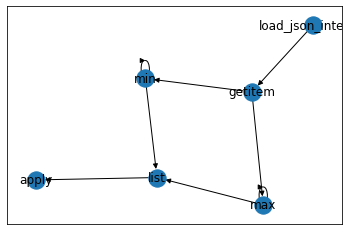

In [53]:
from matplotlib import pyplot as plt
plt.tight_layout()
nx.draw_networkx(dag, arrows=True)

In [54]:
import graphviz
dot = graphviz.Digraph()
for node in dag.nodes:
    dot.node(node)
for edge_str, count in edge_count.items():
    source, destination  = edge_str.split("-")
    dot.edge(source, destination, label=str(count))

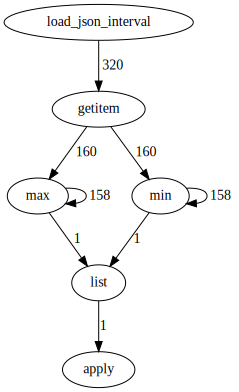

In [55]:
dot

In [67]:
def draw_graph(future):
    dask_graph = future.__dask_graph__()
    edges = []
    edge_count = {}
    for key, value in dask_graph.dependencies.items():
        vals = list(value)
        destination = key.split("-")[0]
        for val in vals:
            source = val.split("-")[0]
            str_edge = str(source) + "-" + str(destination)
            if str_edge not in edge_count:
                edge_count[str_edge] = 0
            edge_count[str_edge] = edge_count[str_edge] + 1
            edges.append((source, destination))
    print(edges[:5])
    import networkx as nx
    dag = nx.DiGraph()
    dag.add_edges_from(edges)
    import graphviz
    dot = graphviz.Digraph()
    for node in dag.nodes:
        dot.node(node)
    for edge_str, count in edge_count.items():
        source, destination  = edge_str.split("-")
        dot.edge(source, destination, label=str(count))
    return dot

In [73]:
INDEX = 'file_id'
JSON_INDEX = 'filenames'
COLUMN = 'proc_id'
MIN, MAX = calculate_interval(INDEX, JSON_INDEX)
with clients[INDEX].as_current():
    pieces = 2**MAX_DEPTH
    interval = math.floor(MAX*1.0/pieces)
    depth = list(range(0, MAX_DEPTH+1))
    depth.reverse()
    output = [0]*(MAX_DEPTH+1)
    time_range = np.arange(MIN, MAX, interval)
    for x in depth:
        depth_ret = []
        if (x == MAX_DEPTH):
            for i in time_range:
                #print(i)
                depth_ret.append(dask.delayed(filter_interval)(INDEX, i, i + interval, COLUMN))
        else:
            pieces = len(output[x+1])
            if pieces % 2 == 1:
                pieces = pieces - 1
            for i in range(0, pieces , 2):
                depth_ret.append(dask.delayed(merge_array)(output[x+1][i], output[x+1][i+1]))
            pieces = len(output[x+1])
            if pieces % 2 == 1:
                depth_ret.append(output[x+1][pieces - 1])
            for index, val in enumerate(output[x+1]):
                output[x+1][index] = dask.delayed(cal_len)(val)
        output[x] = depth_ret

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.130368 to fit


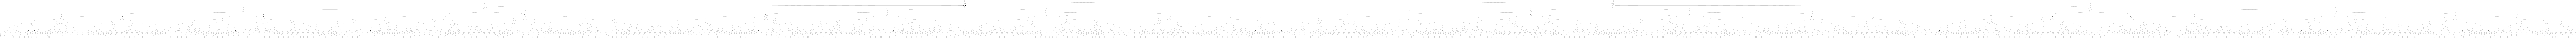

In [74]:
total = dask.delayed(output)()
total.visualize()

In [75]:
dot = draw_graph(total)

[('cal_len', 'list'), ('cal_len', 'list'), ('cal_len', 'list'), ('cal_len', 'list'), ('cal_len', 'list')]


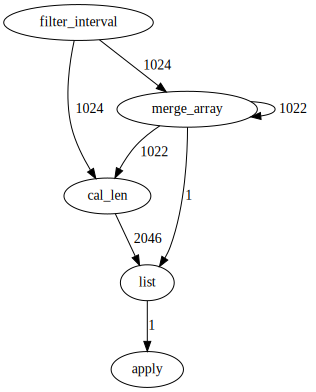

In [76]:
dot

In [57]:
# %%time
# dataframe_memory = ddf.memory_usage(deep=True).compute()
# import psutil
# vmem = psutil.virtual_memory()
# print(vmem)
# dataframe_memory_gb = dataframe_memory.sum()
# is_computed = False
# if dataframe_memory_gb < vmem[0] *.70:
#     is_computed = True
# print(f"We should compute: {is_computed}")

In [58]:
# %%time
# string_list = {}
# for i, index in enumerate(filter_groups_indices):
#     with clients[index].as_current():
#         string_list[index] = []
# with concurrent.futures.ThreadPoolExecutor(max_workers = 2) as executor:
#     index_futures = {executor.submit(calculate_strings, index, json_index): index for json_index, index in [['filenames','filename'], ['processes','hostname']]}
#     for future in concurrent.futures.as_completed(index_futures):
#         index = index_futures[future]
#         try:
#             result = future.result()
#         except Exception as exc:
#             print(f'{index} generated an exception: {exc}')
#         else:
#             print(f'Created strs from json for {index} with len {result}')


In [59]:
#%%time
#clients['filename'].scatter(all_files)
#clients['hostname'].scatter(processes_all)

In [60]:
def reindex(INDEX):
    with clients[INDEX].as_current():
        ddf =  dd.read_parquet(f"{parquet_folder}/partitioned/*.parquet", engine="pyarrow-dataset", index=False)
        ddf_indexed = ddf.set_index([INDEX])
    ddf_indexed = clients[INDEX].persist(ddf_indexed)
    #result = wait(ddf_indexed)
    filter_groups_ddf[INDEX] = ddf_indexed
    return 1

In [61]:
filter_groups_ddf = {}
ddf = reindex('tmid')

In [68]:
dot = draw_graph(filter_groups_ddf['tmid'])

[]


In [70]:
dask_graph = filter_groups_ddf['tmid'].__dask_graph__()

In [72]:
dask_graph.dependencies

{'sort_index-69e1fd99df35cb908de955e5c54d97e3': set()}

In [69]:
dot

In [ ]:
%%time
filter_groups_ddf = {}
with concurrent.futures.ThreadPoolExecutor(max_workers = len(filter_groups_indices)) as executor:
    index_futures = {executor.submit(reindex, index): index for index in filter_groups_indices}
    for future in concurrent.futures.as_completed(index_futures):
        index = index_futures[future]
        try:
            result = future.result()
        except Exception as exc:
            print(f'{index} generated an exception: {exc}')
        else:
            print(f'Created index for {index}')

In [ ]:
%%time
compute_file_metrics(MAX_DEPTH)

In [ ]:
filter_groups_ddf['proc_id'].index

In [ ]:
%%time
compute_process_metrics_2(MAX_DEPTH)

In [ ]:
def compute_process_metrics(MAX_DEPTH):
    INDEX = 'proc_id'
    JSON_INDEX = 'processes'
    COLUMN = 'file_id'
    MIN, MAX = calculate_interval(INDEX, JSON_INDEX)
    process_metrics = calculate_metrics_interval(INDEX, MAX_DEPTH, COLUMN, MIN, MAX)
    return process_metrics

In [ ]:
#%%time
#compute_timeline_metrics(MAX_DEPTH)

In [ ]:
#%%time
#compute_file_metrics(MAX_DEPTH)

In [ ]:
#%%time
#compute_process_metrics(MAX_DEPTH)

In [ ]:
%%time
filter_group_funcs = {'tmid':compute_timeline_metrics, 'proc_id':compute_process_metrics, 'file_id':compute_file_metrics}
filter_groups_metrics = {}
with concurrent.futures.ThreadPoolExecutor(max_workers = len(filter_groups_indices)) as executor:
    index_futures = {executor.submit(filter_group_funcs[index], MAX_DEPTH): index for index in filter_groups_indices}
    for future in concurrent.futures.as_completed(index_futures):
        index = index_futures[future]
        try:
            filter_groups_metrics[index] = future.result()
            print(filter_groups_metrics[index][0][0][0][:5])
        except Exception as exc:
            print(f'{index} generated an exception: {exc}')
        else:
            print(f'Calculated metrics for filtergroup with index: {index}')

In [ ]:
with clients['tmid'].as_current():
    print(filter_groups_ddf['tmid'].index.unique().compute())

In [ ]:
%%time

process_future = dask.delayed(compute_process_metrics)(MAX_DEPTH)
process_metrics, processes_all = process_future.compute()
print(process_metrics[0][0][0][:5])

In [ ]:
%%time
file_future = dask.delayed(compute_file_metrics)(MAX_DEPTH)
file_metrics, files_all = file_future.compute()
print(file_metrics[0][0][0][:5])

In [ ]:
%%time
time_future = dask.delayed(compute_timeline_metrics)(MAX_DEPTH)
timeline_metrics, time_range = time_future.compute()
print(timeline_metrics[0][0][0][:5])

In [ ]:
cluster.scale(n_workers_per_node*2)

In [ ]:
%%time
process_future = local_client.submit(compute_process_metrics, MAX_DEPTH)
process_metrics, processes_all = process_future.result()
print(process_metrics[0][0][0][:5])

In [ ]:
%%time
file_future = local_client.submit(compute_file_metrics, MAX_DEPTH)
file_metrics, files_all = file_future.result()
print(file_metrics[0][0][0][:5])

In [ ]:
%%time
time_future = local_client.submit(compute_timeline_metrics, MAX_DEPTH)
timeline_metrics, time_range = time_future.result()
print(timeline_metrics[0][0][0][:5])

In [ ]:
%%time
if_future = False
#load_timeline_future = timeline_client.submit(compute_timeline_metrics, 10)
#load_file_future = file_client.submit(compute_file_metrics, 10)
if if_future:
    file_client.cancel(load_process_future)
load_process_future = file_client.submit(compute_process_metrics, 3)
if_future = True

In [ ]:
%%time
#timeline_values = load_timeline_future.result()

In [ ]:
#file_cluster.scale(16)

In [ ]:
%%time
processes_all, process_metrics = load_process_future.result()

In [ ]:
print(len(process_metrics[0][0][0]))
for x in range(1,4):
    print("depth ",x," has ", len(process_metrics[0][x-1]), " timesteps")

In [ ]:
MAX_DEPTH = 5
import dask
def filter(filelist):
    #order is important we want to first select correct time range then do filters.
    file_ddf = ddf.loc[filelist]
    read_df, write_df, metadata_df = dask.compute(file_ddf[(file_ddf['io_cat'] == 1)]['hostname'].unique(),
                                                  file_ddf[(file_ddf['io_cat'] == 2)]['hostname'].unique(),
                                                  file_ddf[(file_ddf['io_cat'] == 3)]['hostname'].unique())
    del file_ddf 
    return read_df

def merge(x, y):
    return np.union1d(x, y)

depth = list(range(0, MAX_DEPTH+1))
depth.reverse()
pieces = 2**MAX_DEPTH
interval = math.floor(len(global_files[0][0])*1.0/pieces)
print(tend, interval)
print(depth, pieces)
output = [0]*(MAX_DEPTH+1)
print(output)
for x in depth:
    depth_ret = []
    if (x == MAX_DEPTH):
        for i in range(0, len(), interval):
            #print(i,  i + interval)
            depth_ret.append(dask.delayed(filter)(global_files[0][0][i: i + interval]))
    else:
        pieces_in_next_level = 2**(x+1)
        for i in range(0, pieces_in_next_level , 2):
            depth_ret.append(dask.delayed(merge)(output[x+1][i], output[x+1][i+1]))
    output[x] = depth_ret


In [ ]:
%%time
result = wait(ddf_filename, timeline_ddf)

In [ ]:
#ddf.groupby(['app','func_id'])['func_id'].count().compute()

In [ ]:
#ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [ ]:
#time_df = ddf[ddf['func_id'].isin(["read"])].sample(frac=0.01).compute()

In [ ]:
#time_df.head()

In [ ]:
#time_df[(time_df['io_cat'] == 2)].compute().head()

In [ ]:
#time_df[(time_df['io_cat'] == 3)].compute().head()

In [ ]:
#timeline_cluster.scale(n_workers)

In [ ]:
%%time
with timeline_client.as_current():
    total = dask.delayed(output)()
total.visualize()

In [ ]:
%%time
with timeline_client.as_current():
    
    result = wait(output)

In [ ]:
%%time

#result = wait(ddf_filename)

In [ ]:
#file_ddf = ddf_filename[ddf_filename['size'] > 0].sample(frac=0.01).compute()

In [ ]:
#file_ddf.head()

In [ ]:
#file_ddf.loc[["/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr1.250000.vcf","/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr2.250000.vcf"]]

In [ ]:
#f = open(f'{parquet_folder}/rank_0.json')
#data = json.load(f)
#filenames = data["filenames"]
#print(len(filenames))

In [ ]:
files = glob.glob(f"{parquet_folder}/rank_*.json", recursive=True)
TOTAL_JSON_FILES = len(files)
MAX_DEPTH = math.ceil(math.sqrt(TOTAL_JSON_FILES))
print(MAX_DEPTH)

In [ ]:
%%time
         
with file_client.as_current():
    total = dask.delayed(output)()
total.visualize()

In [ ]:
%%time
         
with file_client.as_current():
    global_files = dask.compute(output)
#result = wait(output)

In [ ]:
print(global_files[0][0])
for x in depth:
    print("depth ",x," has ", len(global_files[0][x-1]), " timesteps")

In [ ]:
%%time
         
with file_client.as_current():
    total = dask.delayed(output)()
total.visualize()

In [ ]:
%%time
         
with file_client.as_current():
    global_files = dask.compute(output)
#result = wait(output)

In [ ]:
print(global_files[0][0])
for x in depth:
    print("depth ",x," has ", len(global_files[0][x-1]), " timesteps")

In [ ]:
tstart=0
tend=33
MAX_DEPTH=1
def recurse(depth=-1):
    depth+=1;
    return_vals = []
    vals = {}
    if (depth < MAX_DEPTH):
        vals =  dask.delayed(recurse)(depth)
    if depth == MAX_DEPTH:
        pieces = 2**depth
        print(pieces)
        interval = math.floor((tend-tstart)*1.0/pieces)
        for i in range(tstart, tend, interval):
            #range_ddf = ddf[(ddf['tstart']>= i) & (ddf['tend']< (i+interval))]
            #range_ddf = range_ddf.to_delayed(optimize_graph=True)
            val = dask.delayed(np.ones)((4, 4))
            return_vals.append(val)
    elif (depth < MAX_DEPTH):
        pieces_in_next_level = 2**(depth+1)
        for i in range(0, pieces_in_next_level-1, 2):
            data = [da.from_array(vals[j]) for j in range(i,i+1)]
            return_vals.append(da.concatenate(data, axis=0))
    vals = return_vals
    return vals
import dask
total = dask.delayed(recurse)()
total.visualize()
#total.compute()

In [ ]:
tstart=0
tend=33
MAX_DEPTH=0
def recurse(ddf, depth=-1):
    depth+=1;
    return_vals = []
    vals = {}
    #if (depth < MAX_DEPTH):
    #    vals = recurse(ddf, depth)
    if depth == MAX_DEPTH:
        pieces = 2**depth
        print(pieces)
        interval = math.floor((tend-tstart)*1.0/pieces)
        for i in range(tstart, tend, interval):
            #range_ddf = ddf[(ddf['tstart']>= i) & (ddf['tend']< (i+interval))]
            #range_ddf = range_ddf.to_delayed(optimize_graph=True)
            val =[1,2] #range_ddf['rank'].unique()
            return_vals.append(val)
    elif (depth < MAX_DEPTH):
        pieces_in_next_level = 2**(depth+1)
        for i in range(0, pieces_in_next_level-1, 2):
            return_vals.append(np.union1d(vals[str(depth+1)][i],vals[str(depth+1)][i+1]))
    vals[str(depth)] = return_vals
    return vals
import dask
total = dask.delayed(recurse)(ddf)
total.visualize()
#vals = total.compute()

In [ ]:
vals

In [ ]:
num_ranks = 160

## Initial Boostrapping

### Read Application logs into dask dataframe

In [ ]:
print("Dask dataframe is split into {} partitions".format(ddf.npartitions))

In [ ]:
print("Columns present in dataset")
print(ddf.columns)

In [ ]:
ddf.head()

#### Only keep level zero from MPI and FTRACE but keep all levels for I/O

In [ ]:
ddf = ddf[(ddf['level'] == 0) | ddf['cat'].isin([0,1,3])]
g1 = ddf.__dask_graph__()
g1.layers
#ddf = ddf.persist()

### Split dataframe into I/O, MPI, and trace

In [ ]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

### Check I/O interfaces used by application

In [ ]:
interfaces = io_ddf['func_id'].unique().compute()
print(interfaces)

Only POSIX interface is used in this application

### Set duration of I/O events

In [ ]:
io_ddf['duration'] = io_ddf['tend'] - io_ddf['tstart']

In [ ]:
negetive_duration = io_ddf[io_ddf['duration'] < 0]['duration'].count().compute()
print("Application Profiler has stored {} negetive values".format(negetive_duration))

### Create conditions for filtering
Even though this application doesnt have MPI or STDIO we have all the conditions here. This is to make sure we cover other apps as well.

In [ ]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

### Extract Filename from each row.
This simplifies analysis later on as we can filter recorder per rank and per file to understand access pattern information.

In [ ]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

Some filename has redundent forward slashes

In [ ]:
io_ddf['filename'] = io_ddf['filename'].str.replace('//','/')

### Filter recorder which have read and write operations and which have metadata.
We assume that there is only two types of operation in I/O read/write and metadata.

In [ ]:
io_ddf_read_write = io_ddf[read_condition | write_condition].compute()
io_ddf_metadata = io_ddf[~read_condition & ~write_condition].compute()

### Build size and count to understand I/O on the io_ddf_read_write dataframe

In [ ]:
open_condition = io_ddf_read_write['func_id'].str.contains("open")
mpi_condition = io_ddf_read_write['func_id'].str.contains("MPI")
read_condition = io_ddf_read_write['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf_read_write['func_id'].isin(["fread"])
close_condition = io_ddf_read_write['func_id'].str.contains('close')
write_condition = io_ddf_read_write['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf_read_write['func_id'].isin(["fwrite"])
readdir_condition = io_ddf_read_write['func_id'].isin(["readdir"])

In [ ]:
io_ddf_read_write['size'] = 0
io_ddf_read_write['count'] = 1
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(read_condition , io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fread_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fread_condition, io_ddf_read_write['args_2'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(write_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fwrite_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fwrite_condition, io_ddf_read_write['args_2'])

#### Corner cases

In [ ]:
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(readdir_condition , "0")
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(readdir_condition , "1")

#### Set Datatypes
This is needed as by default args are string from which they are set.

In [ ]:
io_ddf_read_write = io_ddf_read_write.astype({'size': 'int32','count': 'int32'})

#### Compute Final Size
After this point we do not use count field.

In [ ]:
io_ddf_read_write['size'] = io_ddf_read_write['size'] * io_ddf_read_write['count']

### Calculate Bandwidth in MB/s for I/O operations.
Durations might be incorrect or equal to zero due to profilers resolution issues. Therefore, we do bandwidth calculations for only correct durations.

In [ ]:
correct_dur = ((io_ddf_read_write['tend'] - io_ddf_read_write['tstart']) > 0)
io_ddf_read_write['bandwidth'] = 0
io_ddf_read_write['bandwidth'] = io_ddf_read_write['bandwidth'].mask(correct_dur, io_ddf_read_write['size']*1.0/(io_ddf_read_write['tend'] - io_ddf_read_write['tstart'])/1024.0/1024.0)

### Calculate all relevent filenames in the application
The profiler might see jsrun files and other irrelevant internal files which we filter here.

In [ ]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()

In [ ]:
print("The application accesses {} files across all ranks".format(len(all_filenames)))

### Distribution of Transfer Size and Bandwidth in the application
The transfer size is given by the size column in bytes and the bandwidth is shown in MB/s

In [ ]:
io_ddf_read_write[['size', 'bandwidth']].describe()

### Preload the I/O dataframe for faster analysis

In [ ]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

## Application Analysis

### Num Ranks

In [ ]:
num_ranks = io_ddf_read_write['rank'].nunique()
print("Number of ranks in application {}".format(num_ranks))

### Total I/O amount

In [ ]:
total_io = io_ddf_read_write.groupby('func_id')['size'].sum()/1024.0/1024.0/1024.0
print("Total I/O in application {} GB".format(total_io.sum()))
print("Total I/O per operation in application {} GB".format(total_io))

### I/O per rank

In [ ]:
io_ddf_read_write.groupby(['rank', 'func_id'])['size'].sum()

Every rank performs the same amount of I/O and is evenly distributed amoung the read and write operations

In [ ]:
io_per_rank_gb = io_ddf_read_write.groupby(['rank'])['size'].sum()/1024.0/1024.0/1024.0
io_per_rank_gb.plot(kind='line',figsize=(4,4))

### Operations Per Rank

In [ ]:
io_per_rank_gb = io_ddf_read_write.groupby('rank')['count'].sum()
io_per_rank_gb.plot(kind='line',figsize=(4,4))

### Average I/O Time per process

In [ ]:
time_per_rank = io_ddf_read_write.groupby('rank')['duration'].sum()

In [ ]:
print("time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

In [ ]:
time_per_rank.plot(kind='line',figsize=(4,4))

Even though every rank has identical I/O (operations and amount), they have a variable performance.
- **Possible Reason:**
  - Overwelming of PFS from I/O parallelism.
  - Transfer size doesnt match Stripe size.

### Compute Time

#### Convert trace dataframe into memory.

In [ ]:
trace_ddf_local = trace_ddf.compute()

#### Calculate duration for trace values

In [ ]:
trace_ddf_local['duration'] = trace_ddf_local['tend']-trace_ddf_local['tstart']

In [ ]:
negetive_durations = trace_ddf_local[trace_ddf_local['duration'] < 0]['duration'].count()
print("Profiler stored {} negetive rows".format(negetive_durations))

In [ ]:
time_per_rank = trace_ddf_local.groupby('rank')['duration'].sum()

In [ ]:
print("Time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

In [ ]:
time_per_rank.plot(kind='line',figsize=(4,4))

## Job Time

In [ ]:
job_time = ddf['tend'].max().compute()

In [ ]:
print("Job Time in Application {} sec".format(job_time))

The application run for a long time includes initialization.

## Job Intensity

In [ ]:
total_compute = trace_ddf_local.groupby('rank')['duration'].sum().max()
total_io = io_ddf.groupby('rank')['duration'].sum().max().compute()

In [ ]:
io_intensity=total_io/(total_io + total_compute)
comp_intensity=total_compute/(total_io + total_compute)

In [ ]:
print("I/O intensity: {}, Compute intensity: {}".format(io_intensity, comp_intensity))

## Time spent in Data Operations

In [ ]:
data_ops = ['read', 'write']
total_time_io_data = io_ddf[io_ddf['func_id'].isin(data_ops)].groupby('rank')['duration'].sum().max().compute()
total_time_io_metadata = io_ddf[~io_ddf['func_id'].isin(data_ops)].groupby('rank')['duration'].sum().max().compute()
print("Time spent on data: {} sec, metadata: {} sec".format(total_time_io_data, total_time_io_metadata))

### I/O Transfer Size Distribution

In [ ]:
file_df_temp = io_ddf_read_write
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
size_ranges_str = []
for range_val in size_ranges:
    size_ranges_str.append(str(range_val))
max_range = len(size_ranges)
request_size = [0]*len(size_ranges)
for i, val in enumerate(size_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_size[i] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                       (file_df_temp['size'].lt(size_ranges[i+1]))]['size'].count()
    else:
        request_size[i] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['size'].count()

print(request_size)
plt.bar(size_ranges_str, request_size)
#file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
#plt.hist(file_sizes, bins=100)
plt.show()

The application uses a constant transfer size of 16MB

### Distribution of Bandwidth achived by application

In [ ]:
bw_ranges = [1, 128, 1024, 1024*64]
bw_ranges_str = []
for range_val in bw_ranges:
    bw_ranges_str.append(str(range_val))
max_range = len(bw_ranges)
request_bw = [0]*len(bw_ranges)
for i, val in enumerate(bw_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'].ge(val)) & 
                                       (file_df_temp['bandwidth'].lt(bw_ranges[i+1]))]['size'].count()
    else:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'] >=bw_ranges[i])]['size'].count()
fig, ax = plt.subplots()
ax.barh(bw_ranges_str, request_bw)
for i, v in enumerate(request_bw):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
plt.show()

In [ ]:
request_bw

In [ ]:
percentage_bw = np.array(request_bw)*100/np.sum(request_bw)
percentage_bw

In [ ]:
ranks = range(40)
ranks_str = []
for rank in ranks:
    ranks_str.append(str(rank))
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*len(ranks)
    for j,rank in enumerate(ranks):
        
        file_df_temp = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][j] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][j] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
#fig, ax = plt.subplots(figsize=(16,4))
#width = 0.35
#plt.figure()
for i, val in enumerate(size_ranges):
    plt.figure(figsize=(16,4))
    print(request_size[i][0],np.mean(request_size[i]))
    rects1 = plt.bar(ranks_str, request_size[i], 0.35, label=str(i))
    plt.show()
ax.legend()

fig.tight_layout()

plt.show()

- 71% of the overall I/O got a bandwidth of 1 GB/s per process.
- 27% achieve a low bandwidth of 128MB/s

### Number of files read/written

In [ ]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()
print("The application accesses {} files".format(len(all_filenames)))
#print(all_filenames[:8],all_filenames[-8:])

### I/O Operations by Application

In [ ]:
io_ddf.groupby('func_id')['func_id'].count().compute()

As there are 1280 ranks in total, the distribution of operations is even among the processes.
We will confirm it with random inspections next.

### IO Operations per rank

In [ ]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[:8]

In [ ]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[32:40]

These confirm our hypothesis that HACC-IO performs same operations per process.

### Bandwidth per request distribution
We calculate the achived bandwidth per request size.

In [ ]:
ranks = range(num_ranks)
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*num_ranks
    for rank in range(num_ranks):
        file_df_temp = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][rank] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][rank] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
fig, ax = plt.subplots()
width = 0.35
for i, val in enumerate(size_ranges):
    rects1 = ax.bar(ranks, request_size[i], width, label=str(i))
plt.show()
ax.legend()

fig.tight_layout()

plt.show()

As the application has only one request size 16MB, we see a single line. However, we see variation of upto 10x between bandwidth from few ranks.

### Overlapping of Compute and I/O

In [ ]:
io_ddf.groupby('rank')['thread_id'].nunique().describe().compute()

#### No additional threads means I/O is synchronous to compute. I.e. all I/O is unoverlapped.

### Timeline
The timeline analysis shows how each rank performs I/O over the runtime of the applications

In [ ]:
time_step=1 # in seconds

#### Request Size Timeline

In [ ]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
print(timeline_ts)
plt.bar(values, timeline_ts)

In [ ]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & (read_condition)
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
print(timeline_ts)
plt.bar(values, timeline_ts)

In [ ]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & (write_condition)
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
print(timeline_ts)
plt.bar(values, timeline_ts)

The initial part of the application is spent on init. Based on code inspection this is memory allocation. Then we have I/O operations. Also, as the application has same number of ops a variatic graph depicts that the I/O performance is not consistant during the runtime. Specifically, the I/O performance can reduce 2x-10x during runtime of application.

#### Bandwidth Timeline

In [ ]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
print(timeline_ts)
plt.bar(values, timeline_ts)

In [ ]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & read_condition
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
print(timeline_ts)
plt.bar(values, timeline_ts)

In [ ]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & write_condition
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
print(timeline_ts)
plt.bar(values, timeline_ts)

This supports our previous observation as the bandwidth is the measure of I/O performance of the application.

#### Bandwidth Timeline Per Rank

In [ ]:
import math

selected_rank = [0, 4, 8, 12, 20]
for rank in selected_rank:
    io_df_rank = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    prev = 0
    for i in values_int:
        contains = (io_df_rank['tstart'] >=prev) & (io_df_rank['tend'] <values[i])
        timeline_ts[i] = io_df_rank[contains]['bandwidth'].mean()
        prev = values[i]
    plt.bar(values, timeline_ts)
    plt.show()

As each of the processes in the job perform the same work, the variation in bandwidth means we can optimize the workflow with buffering and caching to reduce the stress and network congestions on the PFS.

#### Request Size Timeline per Rank

In [ ]:
import math

selected_rank = [0, 4, 8, 12, 20]
for rank in selected_rank:
    io_df_rank = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    prev = 0
    for i in values_int:
        contains = (io_df_rank['tstart'] >=prev) & (io_df_rank['tend'] <values[i])
        timeline_ts[i] = io_df_rank[contains]['size'].sum()
        prev = values[i]
    plt.bar(values, timeline_ts)
    plt.show()

### Data Flow
We plot how different ranks in the job are accessing data.

In [ ]:
dependency_graph = {}
for filename in all_filenames:
    dependency_graph[filename]={}

In [ ]:
import graphviz
dot = graphviz.Digraph("rank0",format='pdf')
for rank in [0]:
    dot.node(str(rank))
    io_access_rank = io_ddf[io_ddf['rank'] == rank].groupby(['filename','func_id'])['func_id'].count().compute()
    #print(io_access_rank)
    for index,item in io_access_rank.iteritems():
        filename = index[0]
        func_id = "{}-{}".format(rank,index[1])
        count = item
        #print(filename,func_id,count)
        if "/p/gpfs1" in filename:
            #if filename not in dependency_graph:
            #    dependency_graph[filename]={}
            #if rank not in dependency_graph[filename]:
            #    dependency_graph[filename][rank] = {}
            #if index[1] not in dependency_graph[filename][rank]:
            #    dependency_graph[filename][rank][index[1]] = 0
            #dependency_graph[filename][rank][index[1]] += count
            dot.node(func_id)
            dot.node(filename)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(filename, func_id, label=str(count))
            else:
                dot.edge(func_id,filename, label=str(count))
        

In [ ]:
print(dot.source)

In [ ]:
!dot -Tpdf rank0.dot > rank0.pdf

In [ ]:
dot

Through this we can hypothesize that each process is independently reading and writing data.

## Find file which are independent or shared
- Make all thread id start from 0 and unique across ranks
- Group by filename nunique thread_id
- Find all filename with nunique > 1

In [ ]:
thread_index_series = io_ddf.groupby(['rank', 'thread_id'])['thread_id'].nunique().cumsum().compute()

In [ ]:
io_ddf['thread_index'] = 0
for index,item in thread_index_series.iteritems():
    condition = (io_ddf['rank'] == index[0]) & (io_ddf['thread_id'] == index[1])
    io_ddf['thread_index'] = io_ddf['thread_index'].mask(condition , item - 1)

In [ ]:
threads = io_ddf['thread_index'].nunique().compute()
print("We have {} threads across {} ranks".format(threads, num_ranks))

In [ ]:
filename_series = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')].groupby(['filename'])['thread_index'].nunique().compute()

In [ ]:
independent_files = filename_series[filename_series == 1]
print("{} files that are accessed by application by only one rank".format(len(independent_files)))

In [ ]:
shared_files = filename_series[filename_series > 1]
print("{} files that are accessed by application by more than one rank".format(len(shared_files)))

This application doesnt share files. That is it follows a File per process pattern.

## Calculate Access Pattern
- Calculate segment_index
  - select file_ptr based on open flag
  - update file_ptr based on operation
  - do a cum_sum on file_ptr to calculate final file_ptr
  - assign segment_index based on granularity (median transfer size)
- isolate segment index into
  - sequential flag if segment index is increasing
  - consequitive flag if segment index is increasing and one after the other

#### Persist the current version of I/O dataframe.

In [ ]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Get File operations per rank and per file from the dataframe

In [ ]:
selected_ranks = [0]#range(num_ranks)##
file_per_rank_df = [{}]*len(selected_ranks)
for rank in selected_ranks:
    file_per_rank_df[rank]={}
    io_ddf_rank = io_ddf[io_ddf['rank'] == rank]
    unique_files = io_ddf_rank['filename'].unique().compute()
    for filename in unique_files:
        if filename != '' and '/p/gpfs1' in filename:
            file_per_rank_df[rank][filename] = io_ddf_rank[io_ddf_rank['filename'] == filename].compute()
        

### Check Pattern
We just check if seeks are used. If not it uses a sequential pattern.

In [ ]:
for rank, file_per_rank_df_single in enumerate(file_per_rank_df):
    for filename in file_per_rank_df_single:
        file_df = file_per_rank_df_single[filename]
        ops = file_df['func_id'].unique()
        if "seek" not in ops:
            print("file {} is acessed sequentially by rank {}".format(filename, rank))

There is no seek in any of the file access hence they are sequentially accessed overall.

### Per File Analysis
- Total I/O amount
- Total I/O time (average per process)
- Average Bandwidth
- I/O Request Distribution

In [ ]:
temp_df = io_ddf_read_write
per_file_df = io_ddf_read_write.groupby(['filename'])
temp_df['size_sum'] = per_file_df[["size"]].transform(sum)
temp_df['size_sum'] = temp_df['size_sum'] / 1024.0 / 1024.0
temp_df['time_sum'] = per_file_df[["duration"]].transform(sum)
temp_df['bw_sum'] = per_file_df[["bandwidth"]].transform(np.mean)

per_file_size = temp_df.sort_values("size_sum", ascending=False)["size_sum"]
per_file_time = temp_df.sort_values("time_sum", ascending=False)["time_sum"]
per_file_bw = temp_df.sort_values("bw_sum", ascending=False)["bw_sum"]
print(per_file_size.head())
print(per_file_time.head())
print(per_file_bw.head())